# Лабораторная работа 3
## Фильтр частиц
### Описание системы

В квадратной площадке длиной 100 метров находится мобильный робот. В углах площадки установлены радиомаяки. Робот может измерять расстояние до маяков. Погрешность измерений описывается нормальным распределением с нулевым математически ожиданием и погрешностью $\sigma = 15$. Известно, что начальное положение робота находится в диапазоне координат (0 -100, 0- 100). Начальная ориентация робота составляет $0 \pm 2$ градуса.

Робот функционирует следующим образом:

- Принимает от оператора требуемый угол поворота и дальность перемещения;
- Поворачивается на заданный угол;
- Проезжает заданную дистанцию;
- Измеряет расстояние до маяков;
- Рассчитывает свое положение.

Поворот робота на заданный угол происходит с нормально распределенной погрешностью с нулевым математическим ожиданием и средневадратическим отклонением $\sigma_{\theta} = 2$. Перемещение робота на заданную дистанцию происходит с нормально распределенной погрешностью с нулевым математическим ожиданием и средневадратическим отклонением $\sigma_{l} = 15$.  Требуется построить фильтр частиц для повышения точности локализации робота.

### Задание

- Задать начальное положение робота и средневадратические отклонения;
- Задать не менее 5 команд на перемещение робота;
- Построить траеткторию движения робота с учетом погрешностей;
- Построить фильтр частиц для робота;
- Построить траеткорию движения робота, положения частиц и оценку положения робота после выполнения каждой из команд;
- Выполнить предыдущие пункты для трех различных начальных положений, среднеквадратических отклонений, количества частиц и траекторий движения.

### Решение

#### 0. Импорт библиотек и создание класса для робота

In [23]:
import numpy as np
import matplotlib.pyplot as plt

In [24]:
# Класс робота

class Robot:
    _true_pos = np.zeros([2,1])
    _calc_pos = np.zeros([2,1])
    _ang = 0
    
    _beacon_meas = np.zeros([4,1])
    _x_max = 100
    _x_min = 0 
    _y_max = 100
    _y_min = 0
    
    _sigma_move = 0
    _sigma_turn = 0
    _sigma_meas = 0
    
    
    def __init__(self, x, y, ang, sigma_move, sigma_turn, sigma_meas) -> None:
        # Истинное положение робота и угол
        self._true_pos = np.array([[x], 
                                   [y]], np.float_)
        self._calc_pos = np.array([[0], 
                                   [0]], np.float_)
        self._ang = ang
        # среднеквадратическое отклонение при перемещении
        self._sigma_move = sigma_move
        # среднеквадратическое отклонение при повороте
        self._sigma_turn = sigma_turn
        
        # Измерение расстояния до маяка
        self._beacon_meas = np.array([[0],  # 1 маяк
                                      [0],  # 2 маяк
                                      [0],  # 3 маяк
                                      [0]]) # 4 маяк
        # среднеквадратическое отклонение при измерении
        self._sigma_meas = sigma_meas
        
        
    def turn(self, ang):
        self._ang += ang + np.deg2rad(np.random.normal(0, self._sigma_turn))
        
        return self._ang
        
        
    def move(self, path_len):
        true_len = np.float_(path_len + np.random.normal(0, self._sigma_move))
        self._true_pos[0] += true_len * np.cos(self._ang)
        self._true_pos[1] += true_len * np.sin(self._ang)
        
        # Проверка на выход за границы поля
        # X
        if self._true_pos[0] > self._x_max:
            self._true_pos[0] = self._x_max
        elif self._true_pos[0] < self._x_min:
            self._true_pos[0] = self._x_min
        # Y
        if self._true_pos[1] > self._y_max:
            self._true_pos[1] = self._y_max
        elif self._true_pos[1] < self._y_min:
            self._true_pos[1] = self._y_min
        
        return self._true_pos
    
    
    def make_measurment(self, beacons):
        #  b3(0,y3)*       * b4 (x4, y4)    # Расположегие маяков
        #                                   #
        #                                   #
        #  b1(0,0) *       * b2 (x2, 0)     #
        meas = np.zeros([4,1])
        for i in range(len(meas)):
            meas[i] = np.sqrt((beacons[i][0] - self._true_pos[0])**2 + (beacons[i][1] - self._true_pos[1])**2) + np.random.normal(0, self._sigma_meas)
        self._beacon_meas = meas
        
        return self._beacon_meas
    
    
    def calc_pos(self, beacons):
        # Вычисление положение при помощи трилатерации по двум маякам
        x_calc = (self._beacon_meas[0]**2 - self._beacon_meas[1]**2 + beacons[1][0]**2)/(2*beacons[1][0])
        y_calc = (self._beacon_meas[0]**2 - self._beacon_meas[2]**2 + beacons[2][1]**2)/(2*beacons[2][1])
        self._calc_pos = np.array([[x_calc],
                                   [y_calc]])
        
        return self._calc_pos
        
        
    def get_true_pos(self):
        return self._true_pos
    
    
    def get_calc_pos(self):
        return self._calc_pos
    
    
    def get_ang(self):
        return np.rad2deg(self._ang)

#### 1. Задать начальное положение робота и среднеквадратические отклонения

In [25]:
# Характеристики робота
x_0 = 40
y_0 = 40
ang_0 = (np.random.rand() - 0.5)*2

sigma_move = 15
sigma_turn = 2
sigma_meas = 15

# Координаты маяков
# Расположегие маяков

    #  b3(0,y3)*       * b4 (x4, y4)    # 
    #                                   #
    #                                   #
    #  b1(0,0) *       * b2 (x2, 0)     #
    
beacons = np.array([[0,  0],
                    [100,0],
                    [0,  100],
                    [100,100]])


bot = Robot(x_0, y_0, ang_0, sigma_move, sigma_turn, sigma_meas)

In [26]:
#test
print('ang = ', bot.get_ang())
print('true_pos = ', bot.get_true_pos())
print('calc_pos = ', bot.get_calc_pos())

ang =  32.64444359219182
true_pos =  [[40.]
 [40.]]
calc_pos =  [[0.]
 [0.]]


In [27]:
# test 
bot.move(10)

array([[ 8.9461373 ],
       [20.10626945]])

In [28]:
#test
bot.turn(np.pi/4)

1.3847253130008876

#### 2. Задать не менее 5 команд на перемещение робота

In [29]:
# Массивы команд перемещения
cmnd = np.array([[10, 0],
                 [20, 0],
                 [10, 0],
                 [10, 0],
                 [10, 0]])


true_pos_massive = np.zeros([5,2])
calc_pos_massive = np.zeros([5,2])
massive_y = []
t = []
pos_real_x = 0
pos_real_y = 0


for i in range(5):
    bot.turn(np.pi/2)
    bot.move(30)
    bot.make_measurment(beacons)
    bot.calc_pos(beacons)
    
    
    true_pos_massive[i][:] = bot.get_true_pos().T
    calc_pos_massive[i][:] = bot.get_calc_pos().T
    bot.get_calc_pos
    t.append(i)

#### 3. Построить траеткторию движения робота с учетом погрешностей

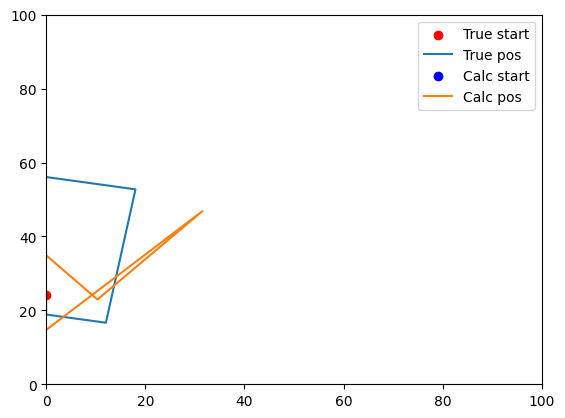

In [30]:

plt.scatter(true_pos_massive[0,0],true_pos_massive[0,1], c='r', label='True start')
plt.plot(true_pos_massive[:,0],true_pos_massive[:,1], label='True pos')

plt.scatter(calc_pos_massive[0,0],calc_pos_massive[0,1], c='b', label='Calc start')
plt.plot(calc_pos_massive[:,0],calc_pos_massive[:,1], label='Calc pos')

plt.ylim([0,100])
plt.xlim([0,100])
plt.legend()
#print(massive_x)

#### 4. Построить фильтр частиц для робота

In [31]:
# Создаем частицы
N_points = 1000

# Веса
weights = np.ones(N_points) / N_points
points = []

points_true_pos_massive = np.zeros([len(cmnd), N_points, 2])
#points_true_pos_massive = []

# Задание рандомных положений
for i in range(N_points):
    points.append(0)
    points[-1] = Robot(np.random.rand() * 100, # рандомная координата X
                   np.random.rand() * 100, # рандомная координата Y
                   np.random.rand() * np.pi*2, # рандомный угол поворота
                   0, 0, 0 # сигмы
                   )
    
for i in range(5):
    for k in range(N_points):
        points[k].turn(np.pi/2)
        points[k].move(30)
        points[k].make_measurment(beacons)
        points[k].calc_pos(beacons)
        
        points_true_pos_massive[i][k][:] = points[k].get_true_pos().T

In [32]:
# Определение вероятности
def prob(pos, pos_dist):
    return 1/np.sqrt(2 * np.pi * sigma_meas) * np.exp( -(np.sqrt((pos[0] - pos_dist[0])**2 + (pos[1] - pos_dist[1])**2))**2 / sigma_meas )

In [38]:
# Обновление весов
def weight_calc(pos, weights, pos_dist):
    for i in range(N_points):
        weights[i] = prob(pos, pos_dist[i])
    weights = weights / np.sum(weights)

    return weights

In [42]:
new_weights = weight_calc(calc_pos_massive[0,:], weights, points_true_pos_massive[0][:][:])
print(np.sum(new_weights))

1.0
